---
### 5. RFM 분석
- RFM strategy example 
- 1. R(high) / F(high) / M(high) : 놓쳐선 안되는 우수고객, 차별화된 서비스 
- 2. R(<span style="color:yellow"> low </span>) / F(high) / M(high)  : 우수고객이나 이탈 우려, 돌아오게 만들기 위한 이벤트/캠페인 
- 3. R(high) / F(<span style="color:yellow"> low </span>) / M(high)  : 구매력은 있으나 많이 사지는 않음. 제품연관성 분석 통한 추천  
- 4. R(high) / F(high) / M(<span style="color:yellow"> low </span>)  : 싼 물건만 자주 삼. 구매금액 증대가 목표, 일정금액 이상 구매시 오퍼 제공 
---

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import datetime as dt 
import koreanize_matplotlib

In [2]:
## dataset loading : 강사가 제공한 파케이 파일 사용 
raw = pd.read_parquet('data/online_retail.gzip')
print(raw.shape)
raw.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


--- 
### 데이터 전처리 
- 1) 비회원 구매는 제외 (CistomerID = null 제외) 
- 2) 매출취소건 제외 (Quantity, UnitPrice < 0 제외) 
- 3) 매출액 컬럼 생성 
- 4) 극단값 제거 
- 5) 중복값 제거 
---

In [3]:
## 1), 2) 비회원 구매건과 매출취소건 제외 & 3) 매출액 컬럼 생성 
raw_valid = raw[(raw['CustomerID'].notnull()) & (raw['Quantity'] > 0) & (raw['UnitPrice'] >0)]
raw_valid['TotalPrice'] = raw_valid['UnitPrice'] * raw_valid['Quantity']
print(raw_valid.shape)
raw_valid.head(2)

(397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


            Quantity      UnitPrice     CustomerID     TotalPrice
count  397884.000000  397884.000000  397884.000000  397884.000000
mean       12.988238       3.116488   15295.941406      22.397000
std       179.331775      22.097877    1713.054565     309.071041
min         1.000000       0.001000   12346.000000       0.001000
25%         2.000000       1.250000   13969.000000       4.680000
50%         6.000000       1.950000   15159.000000      11.800000
75%        12.000000       3.750000   16795.000000      19.800000
max     80995.000000    8142.750000   18287.000000  168469.600000


<AxesSubplot:>

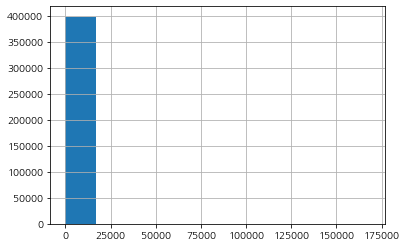

In [4]:
## 매출액 분포 확인 
print(raw_valid.describe())
raw_valid['TotalPrice'].hist()

In [5]:
## 4) 매출액 극단값 제거 
raw_valid = raw_valid[raw_valid['TotalPrice'] < 160000].copy()
raw_valid.shape

(397883, 9)

In [6]:
## 5) 중복값 확인&제거 
print('중복값 갯수 = ', raw_valid.duplicated().sum())
raw_valid[raw_valid.duplicated(keep=False)].sort_values(['InvoiceNo', 'StockCode'])

중복값 갯수 =  5192


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom,4.95
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom,4.95
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom,2.10
...,...,...,...,...,...,...,...,...,...
541655,581538,23275,SET OF 3 HANGING OWLS OLLIE BEAK,1,2011-12-09 11:34:00,1.25,14446.0,United Kingdom,1.25
541656,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom,2.49
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom,2.49
541666,581538,23343,JUMBO BAG VINTAGE CHRISTMAS,1,2011-12-09 11:34:00,2.08,14446.0,United Kingdom,2.08


In [7]:
df = raw_valid.drop_duplicates().copy()
df.shape

(392691, 9)

---
### RFM 계산하기 
- 0) 전처리 (for Recency): InvoiceData를 날짜타입으로 변경 & 최근 거래기준일자 설정
- 1) Recency: 최근 거래기준일자와 고객별 최근 구매일자의 차이 
- 2) Frequency: 구매 빈도
- 3) Monetary: 총 구매액 
---

In [8]:
## transform to datetime type 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.dtypes

InvoiceNo            category
StockCode            category
Description          category
Quantity                int32
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float32
Country              category
TotalPrice            float64
dtype: object

In [9]:
## 최근 거래기준 일자 : 오늘 구매했으며 1일로 표현하기 위해, max(InvoiceDate) + 1 
last_timestamp = df['InvoiceDate'].max() + dt.timedelta(days= 1)
last_timestamp

Timestamp('2011-12-10 12:50:00')

In [10]:
## 고객별 RFM 구하기 
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x : (last_timestamp - x.max()).days, 
                                    'InvoiceNo': 'count', 
                                     'TotalPrice' : 'sum'
                                   })
rfm

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


In [11]:
## RFM의 이름 변경 
#rfm = rfm.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice':'Monetary'})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.583679    90.523513    2009.852304
std     100.019339   225.507058    8622.507371
min       1.000000     1.000000       2.900000
25%      18.000000    17.000000     306.452500
50%      51.000000    41.000000     668.495000
75%     142.750000    98.000000    1659.132500
max     374.000000  7676.000000  280206.020000


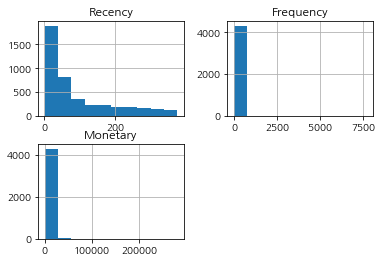

In [12]:
print(rfm.describe())
rfm.hist(bins=10) ;

[Text(0.5, 1.0, 'Monetary')]

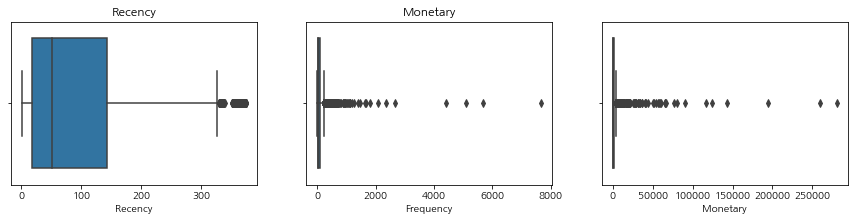

In [13]:
figure, (ax1,ax2,ax3) = plt.subplots(ncols=3)
figure.set_size_inches(15,3)
sns.boxplot(data=rfm, x='Recency', ax=ax1)
sns.boxplot(data=rfm, x='Frequency', ax=ax2)
sns.boxplot(data=rfm, x='Monetary', ax=ax3)
ax1.set(title = 'Recency')
ax2.set(title = 'Frequency')
ax2.set(title = 'Monetary')

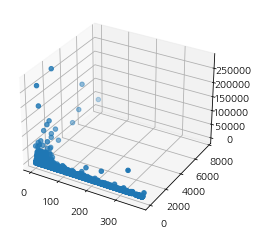

In [14]:
## 참고. RFM 3D projection 
ax = plt.axes(projection = '3d')
ax.scatter3D(rfm['Recency'], rfm['Frequency'], rfm['Monetary'])

---
### RFM scoring & segmentation
- 위의 차트에서 본것과 같이, RFM 원래의 값을 가지고 분석하기가 어렵다. -> segmentation 
- R은 최근일수록(값이 작을수록) 높은 점수를, F와 M은 높을수록 높은 점수 부여 
- RFM 값들을 20%씩 5개의 구간으로 분리, 고객별로 RFM 구간별 점수와 합계값을 계산 
---

In [15]:
## labeing, 점수구간은 5개  
r_labels = list(range(5,0, -1))
f_labels = list(range(1,6, 1))
m_labels = list(range(1,6, 1))
cut_size = 5

In [16]:
## RFM 값들을 5개의 구간으로 구분 (각 구간 비율은 20%)
## pd.cut() vs. pd.qcut() : cut()은 절대평가,특정값을 기준으로 구분. qcut()은 상대평가,특정비율을 기준으로 구분 
r_qcut = pd.qcut(x= rfm['Recency'], q= cut_size, labels= r_labels)
f_qcut = pd.qcut(x= rfm['Frequency'], q= cut_size, labels= f_labels)
m_qcut = pd.qcut(x= rfm['Monetary'], q= cut_size, labels= m_labels)

print(r_qcut.value_counts(normalize=True))
print(f_qcut.value_counts(normalize=True))
print(m_qcut.value_counts(normalize=True))

4    0.204703
5    0.203550
1    0.199631
3    0.197787
2    0.194329
Name: Recency, dtype: float64
1    0.213693
4    0.199401
5    0.198709
3    0.195251
2    0.192946
Name: Frequency, dtype: float64
1    0.200092
3    0.200092
5    0.200092
2    0.199862
4    0.199862
Name: Monetary, dtype: float64


In [17]:
## RFM score 컬럼 생성 : assign 함수 사용 
rfm = rfm.assign(R= r_qcut, F= f_qcut, M= m_qcut)
print(rfm.shape)
rfm.head()

(4338, 6)


,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,2,182,4310.00,5,5,5
12348.0,75,31,1797.24,2,3,4
12349.0,19,73,1757.55,4,4,4
12350.0,310,17,334.40,1,2,2


In [18]:
## total RFM score 
rfm['RFM_score'] = rfm[['R','F','M']].astype(int).sum(axis=1)
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,7
12347.0,2,182,4310.00,5,5,5,15
12348.0,75,31,1797.24,2,3,4,9
12349.0,19,73,1757.55,4,4,4,12
12350.0,310,17,334.40,1,2,2,5
...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,3
18281.0,181,7,80.82,1,1,1,3
18282.0,8,12,178.05,5,1,1,7


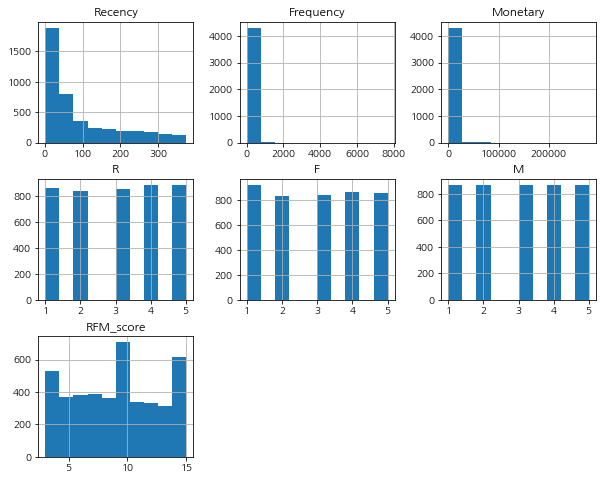

In [19]:
rfm.astype(int).hist(bins=10, figsize=(10,8)) ;

- segmentaion결과 R/F/M & RFM_score가 균등한 분포를 갖게 되었다. 

In [20]:
## RFM_score 구간별로 실제 값들의 평균을 살펴보자 
rfm.groupby('RFM_score').agg({'Recency':'mean', 
                              'Frequency':'mean', 
                              'Monetary':['mean','sum'], 
                             }).style.background_gradient().format('{:,.0f}')

- 최고등급(RFM_score=15) 고객들은 평균적으로 최근 5일이내에 구매하였고, 구매빈도는 평균 439회, 구매금액은 평균 11천 파운드 & 합계 358만 파운드를 구매했다. 

---
### 실전 고객등급 구분 하기 
- RFM score 기준으로 silver, gold, platinum의 3등급 만들기 
---

In [21]:
rfm.head(2)

,Recency,Frequency,Monetary,R,F,M,RFM_score
CustomerID,,,,,,,
12346.0,326,1,77183.6,1,1,5,7
12347.0,2,182,4310.0,5,5,5,15


In [22]:
rfm['RFM_class'] = pd.qcut(x=rfm['RFM_score'], q = 3, labels = ['silver', 'gold', 'platinum'])
rfm

,Recency,Frequency,Monetary,R,F,M,RFM_score,RFM_class
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,7,silver
12347.0,2,182,4310.00,5,5,5,15,platinum
12348.0,75,31,1797.24,2,3,4,9,gold
12349.0,19,73,1757.55,4,4,4,12,platinum
12350.0,310,17,334.40,1,2,2,5,silver
...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,3,silver
18281.0,181,7,80.82,1,1,1,3,silver
18282.0,8,12,178.05,5,1,1,7,silver


In [23]:
rfm.groupby('RFM_class')['RFM_score'].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,1668.0,5.209832,1.384324,3.0,4.0,5.0,6.0,7.0
gold,1409.0,9.469127,1.114505,8.0,8.0,9.0,10.0,11.0
platinum,1261.0,13.471055,1.124120,12.0,12.0,13.0,14.0,15.0


- silver : RFM_score 3~7점 
- gold : RFM_score 8~11점 
- platinum : RFM_score 12~15점 

In [24]:
rfm.groupby('RFM_class').agg({'Recency':['count','mean'], 
                              'Frequency':'mean', 
                              'Monetary':['mean','sum'], 
                             }).style.background_gradient().format('{:,.0f}')

- 전체 고객들이 실버,골드,플래티넘으로 각 1/3씩 차지하도록 구분됨 
- 플래티넘 고객들은 평균적으로 최근 20일이내에 구매하였고, 구매빈도는 평균 227회, 구매금액은 평균 52백 파운드 & 합계 661만 파운드를 구매했다. 

            Recency  Frequency  Monetary  RFM_score
Recency    1.000000  -0.206618 -0.122937  -0.700621
Frequency -0.206618   1.000000  0.444920   0.404260
Monetary  -0.122937   0.444920  1.000000   0.250433
RFM_score -0.700621   0.404260  0.250433   1.000000


<AxesSubplot:>

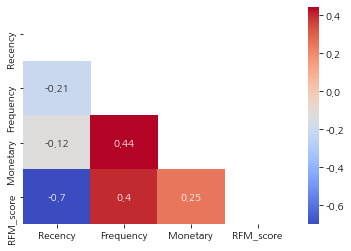

In [25]:
## R,F, M vs RFM_class의 corr 구하고 이를 시각화 
corr = rfm.corr()
print(corr)

## corr matrix의 상/하단부를 지우기 위해 mask 적용 
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask)

- Recency, 즉 최근 구매여부가 RFM score에 가장 큰 영향을 미치는 변수임 

In [26]:
## 다음분석을 위해 데이터 저장 
## 주의!. index = CustomerID 이므로, index=Flase 옵션을 사용하지 않음 
rfm.to_csv('data/rfm.csv')